In [1]:
from imports import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [4]:
timeseries = process_file()
len(timeseries)

154

In [5]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

#### Defining grid search

In [10]:
from model import train_model, evaluate_model_last_prediction, LSTMModel


In [11]:
from sklearn.model_selection import ParameterGrid

# Define grid search hyperparameters
grid = ParameterGrid({
    'lookback': [3],
    'output_size': [1],
    'n_epochs': [300],
    'batch_size' : [7,14],
    'hidden_size': [15], #, 25], #, 50],
    'num_layers': [1], # , 2],
    'lr': [0.001, 0.01]
})
    

In [12]:
from utils import scale_data
from time import time

def evaluate(hyper_params):

    X_train, y_train = create_dataset(train, lookback=hyper_params['lookback'])
    X_test, y_test = create_dataset(test, lookback=hyper_params['lookback'])    
    
    X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_data(X_train, X_test, y_train, y_test)
    
    # print("X_train", X_train.shape, "y_train", y_train.shape)
    # print("X_test",X_test.shape, "y_test",y_test.shape)
    
    model = LSTMModel(input_size=hyper_params['lookback'], hidden_size=hyper_params['hidden_size'], 
                      num_layers=hyper_params['num_layers'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(
        data.TensorDataset(X_train, y_train), shuffle=True, batch_size=hyper_params['batch_size'], 
        drop_last=True
    )
    t0 = time()    
    # Train the model
    train_losses, train_rmse = train_model(model, loader, optimizer, loss_fn, n_epochs=hyper_params['n_epochs'], 
                                           print_interval=50, seed=42)
    train_time = time() - t0
    # Evaluate the model
    train_preds, train_loss, test_loss, train_rmse, test_rmse, test_preds = evaluate_model_last_prediction(
        model, X_train, y_train, X_test, y_test, scaler_y, loss_fn
    )
    
    final_train_loss = train_loss[-1]
    final_test_loss = test_loss[-1]

    result = hyper_params.copy()
    metrics = {
        'final_train_loss': final_train_loss,
        'final_test_loss': final_test_loss,
        'train_losses': train_losses,
        'train_time': train_time
    }
    result.update(metrics)
    return result
    

In [13]:
import pickle as pkl
from tqdm.auto import tqdm

experiments = []
for hyper_params in tqdm(grid):
    experiments.append(evaluate(hyper_params))
    
    with open('experiments.pkl', 'wb') as f:
        pkl.dump(experiments, f)


  0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
exps_df = pd.DataFrame(experiments)

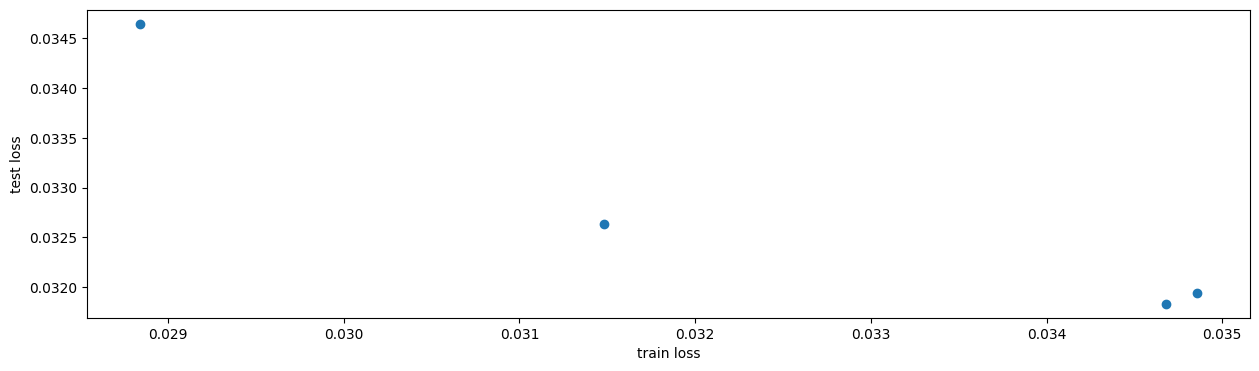

In [15]:
plt.figure(figsize=(15,4))
plt.scatter(exps_df.final_train_loss, exps_df.final_test_loss)
plt.xlabel('train loss')
plt.ylabel('test loss');

In [65]:
exps_df.head()

,batch_size,hidden_size,lookback,lr,n_epochs,num_layers,output_size,final_train_loss,final_test_loss,train_losses
0,7,15,3,0.001,300,1,1,0.031043,0.030844,"[3.3822386413812637, 2.5196205973625183, 1.782..."
1,7,15,3,0.010,300,1,1,0.014564,0.038444,"[1.5696399435400963, 0.662888815626502, 0.5952..."
2,14,15,3,0.001,300,1,1,0.032809,0.033414,"[1.6814110279083252, 1.4906558841466904, 1.278..."
3,14,15,3,0.010,300,1,1,0.018074,0.039334,"[1.0706552863121033, 0.4251920059323311, 0.325..."


#### Defining LSTM Model and hyperparameters

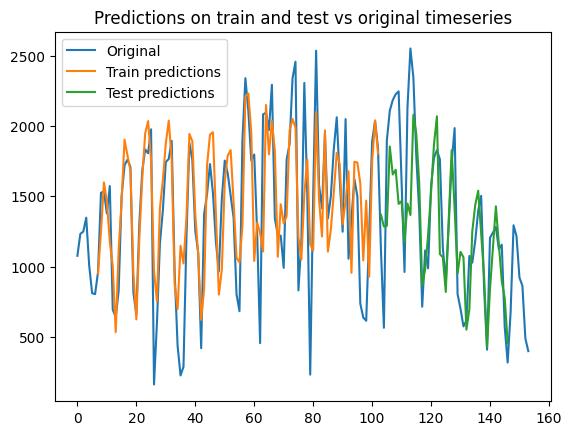

In [40]:
plt.plot(timeseries, label="Original")
plt.plot(range(lookback, lookback + len(train_preds)), train_preds, label="Train predictions")
plt.plot(range(lookback + len(train_preds), lookback + len(train_preds) + len(test_preds)), test_preds, label="Test predictions")
plt.title("Predictions on train and test vs original timeseries")
plt.legend()

In [281]:
test_loss, train_loss

([0.03694296255707741], [0.0240829698741436])

#### Plotting correlation results

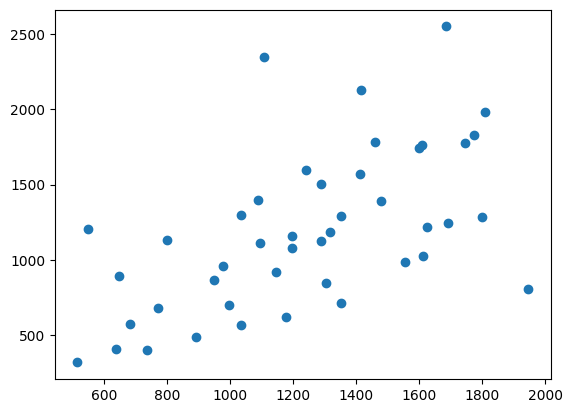

In [305]:
plt.scatter(test_preds, test[lookback:])

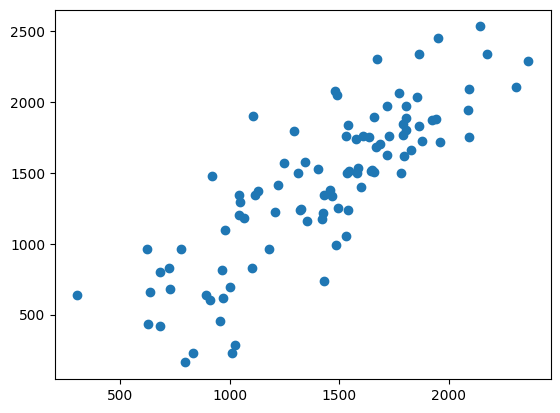

In [306]:
plt.scatter(train_preds, train[lookback:])